<a id="Table-Of-Contents"></a>
# Содержание
* [1. Описание задачи](#Task-Details)
* [2. Анализ данных](#Data-Analysis)
    * [2.1 Импорт библиотек](#Importing-Libraries)
    * [2.2 Вспомогательные функции](#Helper-functions)
    * [2.3 Описание переменных](#Feature-Description)
    * [2.4 Чтение данных и превый взгляд на них](#Read-in-Data)
* [3. Решения по переменным](#Solutions-for-variables)
* [4. Вопросы заказчика](#Customer-Questions)
    * [4.1 Алгоритм выбора актуальных задаче предсказания качества вина признаков](#Outl-detection)
    * [4.2 Алгоритм определения выбросов в данных для выделения классов вин "excellent" и "poor"](#Feature-selection)
    * [4.3 Алгоритм предсказания качества вина](#ML)
* [5. Выводы](#Conclusion)

<a id="Task-Details"></a>
# 1. Описание задачи

**The goal** - to predict the quality of wines depending on their physicochemical composition.


The dataset was downloaded from the UCI Machine Learning Repository.

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. The reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are munch more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

Two datasets were combined and few values were randomly removed.

* [Содержание](#Table-Of-Contents)

<a id="Data-Analysis"></a>
# 2. Анализ данных

<a id="Importing-Libraries"></a>
# 2.1 Импорт библиотек

In [149]:
import os
import sys
import pickle
import bz2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.cluster import DBSCAN

from imblearn.over_sampling import SMOTE

In [150]:
pd.set_option('display.max_rows', None)

* [Содержание](#Table-Of-Contents)

<a id="Helper-functions"></a>
# 2.2 Вспомогательные функции

In [151]:
# загрузка данных с KAGGLE
path_to_local_data = os.path.abspath(os.path.relpath(os.getcwd(), start = 'wine_quality_prediction'))
path_to_kaggle_data = 'rajyellow46/wine-quality'
path_to_KAGGLE_CONFIG_DIR = '/Users/ivanpetrov/Desktop/DataScientiest/KAGGLE_CONFIG_DIR'

sys.path.append(path_to_local_data + '/scripts')

from load_kaggle_data import load_kaggle_data

load_kaggle_data(path_to_KAGGLE_CONFIG_DIR, path_to_kaggle_data, path_to_local_data + '/data')

KAGGLE_CONFIG_DIR = /Users/ivanpetrov/Desktop/DataScientiest/KAGGLE_CONFIG_DIR
Kaggle API 1.5.12




100%|██████████| 98.0k/98.0k [00:00<00:00, 2.82MB/s]


In [171]:
# вывод нескольких однотипных графиков
def plot_graph(df_, list_x, list_y = None, titles_ = None, figsize_ = (18, 1.5), type_ = 'boxplot', xbound_ = None):
    axes = []
    fig, axs = plt.subplots(1, len(list_x), sharey = False, figsize = figsize_)      
    if len(list_x) > 1:
        axes = axs
    else:
        axes.append(axs)
    for ind, ax in enumerate(axes): 
        if type_ == 'boxplot':
            ax.boxplot(df_[list_x[ind]], False, 'r*', vert = False)
            ax.set_title(list_x[ind])
            ax.set_xbound(lower = xbound_[ind][0], upper = xbound_[ind][1])
            ax.set_yticklabels([])
        elif type_ == 'scatter':
            ax.scatter(df_[list_x[ind]], df_[list_y[ind]], marker = '.')
            ax.set_ylabel(list_y[ind])
            ax.set_xlabel(list_x[ind])
        elif type_ == 'hist':
            ax.hist(df_[list_x[ind]], bins = 30)
            #ax.set_xlabel(list_x[ind])
            ax.set_xbound(lower = xbound_[ind][0], upper = xbound_[ind][1])
            ax.set_yticklabels([])
    plt.savefig(path_to_local_data + '/results/' + type_ + '_' + df_.name)
    plt.show()
    return
    
# вывод "тепловой" карты
def heatmap(df_, size, df_name):
    plt.figure(figsize = size)
    sns.heatmap(df_, cmap = 'Blues', annot = True, cbar = True)
    plt.savefig(path_to_local_data + '/results/heatmap_' + df_name)
    plt.show()
    return
    
# выбросы
def outliers(df_, column_, contamination_ = .5):
    pred = IsolationForest(n_estimators = 100, \
                           contamination = contamination_, \
                           random_state = 42).fit_predict(df_[column_])
    print(f'{column_}: {len(np.where(pred == -1)[0])} сэмпл., {np.where(pred == -1)[0]}')
    if len(column_) == 1:
        plt.figure(figsize = (12, 3))
        plt.scatter(df_[column_], df_['quality'], c = 'b')
        plt.scatter(df_.iloc[np.where(pred == -1)[0]][column_], df_.iloc[np.where(pred == -1)[0]]['quality'], c = 'r')
        plt.savefig(path_to_local_data + '/results/outliers' + '_' + df_.name + '_' + column_[0].replace(' ', '_'))
        plt.show()      
    return df_.iloc[np.where(pred == -1)[0]]

# формирование тестового и тренировочного наборов данных
def split_and_smote(df_, oversampling_ = True):
    X_tr, X_t, y_tr, y_t = train_test_split(df_.drop(columns = ['quality']), \
                                            df_['quality'], \
                                            test_size = 0.2, shuffle = True, stratify = df_['quality'], \
                                            random_state = 42)    
    if oversampling_:
        print(f'Размерность до применения SMOTE: X_tr {X_tr.shape}, y_tr {y_tr.shape}')
        smote = SMOTE(sampling_strategy = 'not majority', k_neighbors = 2, random_state = 42)
        X_tr, y_tr = smote.fit_resample(X_tr, y_tr)
        print(f'Размерность после применения SMOTE: X_tr {X_tr.shape}, y_tr {y_tr.shape}')
    return X_tr, X_t, y_tr, y_t

# тестирование модели
def evaluate_solution(y_t, pred_proba, pred_labels, labels = None):
    print(f'ROC AUC на тестовом наборе: {roc_auc_score(y_t, pred_proba, multi_class = "ovr")}')
    print('---------------------------------------------------------')
    print(f'Отчет о классификации:\n\n{classification_report(y_t, pred_labels, labels = labels)}')
    print('---------------------------------------------------------')
    print(f'Матрица ошибок:\n\n{confusion_matrix(y_t, pred_labels)}')
    print('---------------------------------------------------------')
    return

# подбор гиперпараметров модели
def GridSearchCrossVal(estimator_, params_, X_tr, y_tr):
    gscv = GridSearchCV(estimator_, params_)
    gscv.fit(X_tr, y_tr)
    return gscv

# выбор лучшей модели
def models_results(params_, X_tr, X_t, y_tr, y_t, df_name):
    results = {}
    for key in params_:
        print(f'----------------------\n{key}\n----------------------')
        # подбор гиперпараметров модели
        gscv = GridSearchCrossVal(params_.get(key)[0], params_.get(key)[1], X_tr, y_tr)
        # вывод результатов тестирования модели
        evaluate_solution(y_t, gscv.best_estimator_.predict_proba(X_t), gscv.best_estimator_.predict(X_t))
        # сохраним обученную модель в словарик на всякий случай
        results[key] = gscv
        # сохраним обученную модель в файлик на всякий случай
        with open(path_to_local_data + '/models/' + df_name + '_' + key, 'wb') as file:
            pickle.dump(bz2.compress(pickle.dumps(gscv)), file)            
    return results

* [Содержание](#Table-Of-Contents)

<a id="Feature-Description"></a>
# 2.3 Описание переменных

**Input** variables (based on physicochemical tests):  
    1 - fixed acidity: The predominant fixed acids found in wines are tartaric, malic, citric, and succinic. Their respective levels found in wine can vary greatly and wines with high acidity might taste sour which effect the quality.  
    2 - volatile acidity: The amount of acetic acid in wine, which at too high of levels can lead to an unpleasant taste.  
    3 - citric acid: Similar as above, very less in wine.  
    4 - residual sugar: This effect the sweetness of the wine.  
    5 - chlorides: This will stay in the form of potassium salt in wine.  
    6 - free sulfur dioxide: The SO2 exists in equilibrium, too much will effect the health.  
    7 - total sulfur dioxide: Amount of free and bound forms of S02  
    8 - density: During the fermentation process, fructose is converted into alcohol, the density is reduced also influence the taste.  
    9 - pH: Describes how acidic or basic a wine is, most wines are between 3–4. Monitoring the total acidity of red wine is an important indicator of its quality and an important influencing factor of its taste.  
    10 - sulphates: It has the effects of selection, clarification, anti-oxidation, acidification, dissolution, etc. it used to keep it fresh and taste, and maintain the wine flavor.  
    11 - alcohol: The percent alcohol content of the wine  
**Target** variable (based on sensory data):   
    12 - quality (score between 0 and 10)
  
  * [Содержание](#Table-Of-Contents)

<a id="Read-in-Data"></a>
# 2.4 Чтение данных и первый взгляд на них

In [153]:
# чтение данных по винам
df = pd.read_csv(path_to_local_data + '/data/winequalityN.csv', sep = ',')

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [155]:
np.unique(df['type'], return_counts = True)

(array(['red', 'white'], dtype=object), array([1599, 4898]))

Переменная типа вина "type" не сбалансирована (наблюдений красного вина в 3 раза меньше).  
Учитывая вероятное наличие систематических отклонений в сэмплах в заисимости от типа вина, следует проводить анализ данных в разрезе типа вина раздельно.

  * [Содержание](#Table-Of-Contents)

<a id="Solutions-for-variables"></a>
# 3. Решения по переменным

In [156]:
# NaN
print(f'Сэмплов с "NaN": {len(df[df.isna().any(1)])} или {round(len(df[df.isna().any(1)]) * 100.0 / len(df), 2)}%')

Сэмплов с "NaN": 34 или 0.52%


Количество сэмплов с 'NaN' около 0,5%. Решаем удалить их.

In [157]:
df.dropna(axis = 0, inplace = True)
print(f'Сэмплов с "NaN": {len(df[df.isna().any(1)])} или {round(len(df[df.isna().any(1)]) * 100.0 / len(df), 2)}%')

Сэмплов с "NaN": 0 или 0.0%


In [158]:
# разделим данные по типу вина red/white
df_red = df[df['type']=='red'].drop(columns = ['type'])
df_red.name = 'red'
df_white = df[df['type']=='white'].drop(columns = ['type'])
df_white.name = 'white'

In [159]:
df_red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000
mean,8.326365,0.527659,0.271551,2.538512,0.087497,15.841808,46.463905,0.996752,3.310590,0.657866,10.419617,5.636535
std,1.740681,0.179297,0.194843,1.412061,0.047134,10.436038,32.913696,0.001888,0.154305,0.169716,1.065206,0.807687
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997850,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [160]:
df_white.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000
mean,6.855123,0.278071,0.334199,6.394343,0.045771,35.317146,138.340144,0.994026,3.188154,0.489700,10.516772,5.878029
std,0.843444,0.100528,0.120915,5.070853,0.021846,17.012967,42.490515,0.002993,0.150902,0.114196,1.231251,0.885699
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991720,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993735,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


Анализ статистик признаков в разрезе типа вина показывает наличие существенных различий большинства характеристик вин в зависимости от типа "белое/красное".

In [161]:
# целевая переменная
print(f'Красные вина: {np.unique(df_red["quality"], return_counts = True)}')
print(f'Белые вина: {np.unique(df_white["quality"], return_counts = True)}')

Красные вина: (array([3, 4, 5, 6, 7, 8]), array([ 10,  52, 680, 634, 199,  18]))
Белые вина: (array([3, 4, 5, 6, 7, 8, 9]), array([  20,  162, 1448, 2186,  875,  174,    5]))


Целевая переменная в обоих наборах данных не сбалансирована: налицо явное преобладание вин со средней оценкой.

* [Содержание](#Table-Of-Contents)

<a id="Customer-Questions"></a>
# 4. Вопросы заказчика

<a id="Feature-selection"></a>
# 4.1 Алгоритм выбора признаков, актуальных задаче предсказания качества вина

Проблему выбора актуальных признаков попробуем решить с помощью методики многофакторного дисперсионного анализа, который позволит нам проверить гипотезы о важности тех или иных признаков для наших наборов данных по винам.

Первым шагом попробуем определить наличие проблемы мультиколинеарности в наборах данных по винам.

Как видно из информации о каждом столбце выше, значение рН зависит от количества кислоты (acidity) в вине, а плотность (density) от количества алкоголя (alcohol). Свободный диоксид серы (free sulfur dioxide) входит в состав общего диоксида серы (total sulfur dioxide). Citric acid является составной частью fixed acidity.

Проверим наличие взаимосвязи перечисленных выше признаков.

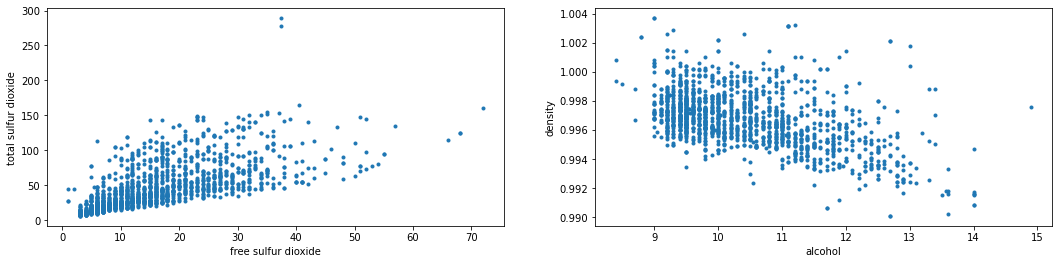

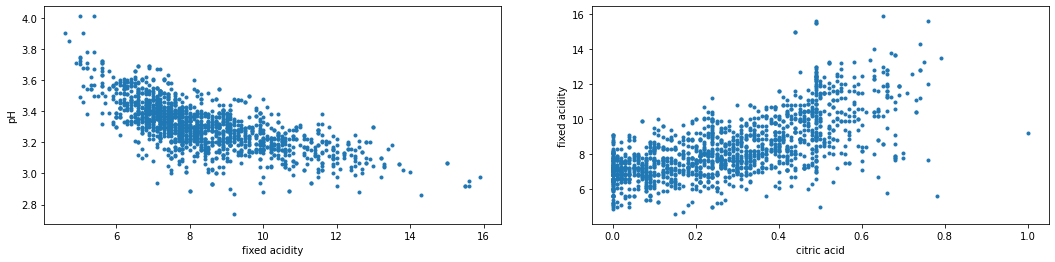

In [162]:
# красное вино
list_x = ['free sulfur dioxide', 'alcohol', 'fixed acidity', 'citric acid']
list_y = ['total sulfur dioxide', 'density', 'pH', 'fixed acidity']
grid_columns = 2
for x in range(0, len(list_x) // grid_columns):
    plot_graph(df_red, list_x[x * grid_columns : (x * grid_columns) + grid_columns], \
               list_y[x * grid_columns : (x * grid_columns) + grid_columns], titles_ = None, \
               figsize_ = (18, 4), type_ = 'scatter')
pass

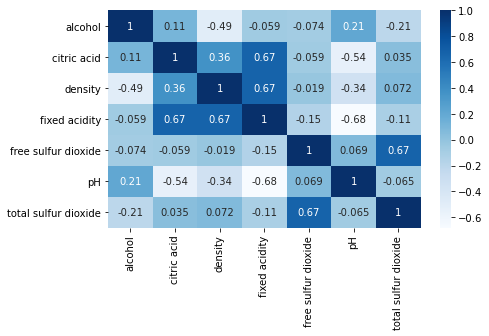

In [165]:
heatmap(df_red[np.unique(list_x + list_y)].corr(), (7, 4), df_red.name)

Значимая корреляция признаков для красного вина присутствует. 

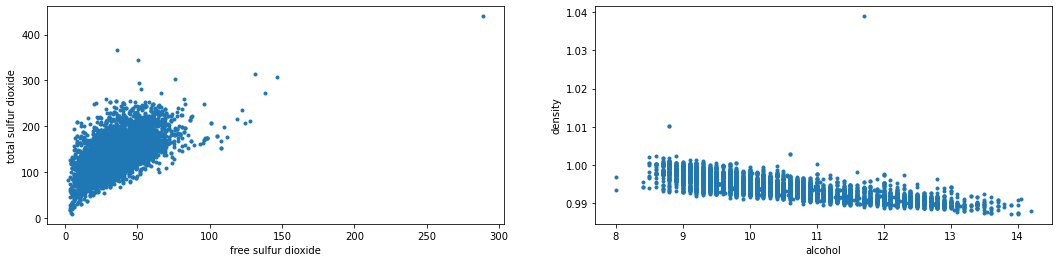

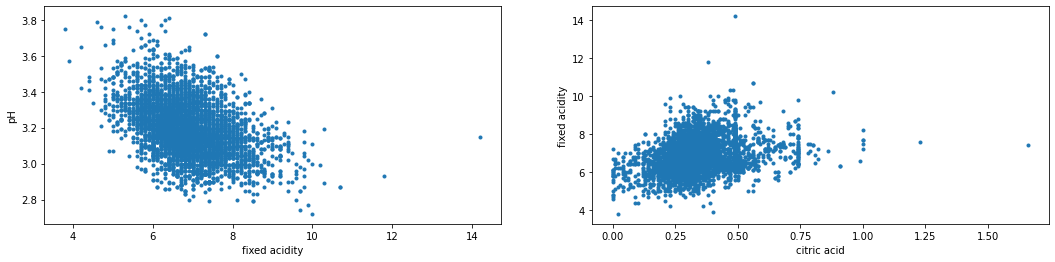

In [166]:
# белое вино
list_x = ['free sulfur dioxide', 'alcohol', 'fixed acidity', 'citric acid']
list_y = ['total sulfur dioxide', 'density', 'pH', 'fixed acidity']
grid_columns = 2
for x in range(0, len(list_x) // grid_columns):
    plot_graph(df_white, list_x[x * grid_columns : (x * grid_columns) + grid_columns], \
               list_y[x * grid_columns : (x * grid_columns) + grid_columns], titles_ = None, \
               figsize_ = (18, 4), type_ = 'scatter')
pass

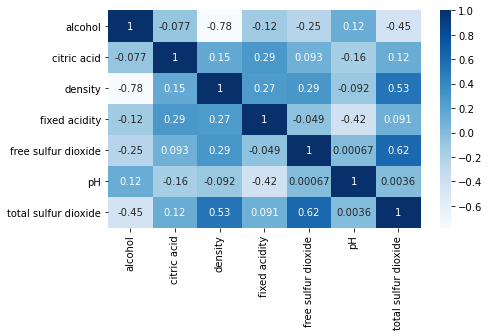

In [167]:
heatmap(df_white[np.unique(list_x + list_y)].corr(), (7, 4), df_white.name)

Картинка несколько изменилась, но значимая корреляция признаков для белого вина также присутствует.

Для исключения проблемы мультиколинеарности уберем несколько признаков из наборов данных, а именно: 'citric acid', 'density', ''free sulfur dioxode', 'pH'. Оставшиеся признаки будут участвовать в построении линейной модели и определении их значимости для предсказания целевой переменной 'quality'.

Примем за нулевую гипотезу отсутствие значимости оставшихся признаков для определения 'quality'.  
Уровень значимости равен 0.05.

In [168]:
# красное вино
from statsmodels.formula.api import ols

data = df_red[['fixed acidity', 'volatile acidity', 'residual sugar', 
               'chlorides', 'total sulfur dioxide','sulphates', 'alcohol', 
               'quality']].rename(columns = {'fixed acidity' : 'fixed_acidity', \
                                             'volatile acidity' : 'volatile_acidity', \
                                             'residual sugar' : 'residual_sugar', \
                                             'total sulfur dioxide' : 'total_sulfur_dioxide' \
                                        })

print(ols('quality ~ fixed_acidity + volatile_acidity + residual_sugar + chlorides + total_sulfur_dioxide' + \
          ' + sulphates + alcohol', data = data).fit().summary().tables[1])

                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.7458      0.233     11.776      0.000       2.288       3.203
fixed_acidity            0.0213      0.010      2.119      0.034       0.002       0.041
volatile_acidity        -1.0879      0.100    -10.911      0.000      -1.284      -0.892
residual_sugar           0.0103      0.012      0.860      0.390      -0.013       0.034
chlorides               -1.7393      0.393     -4.431      0.000      -2.509      -0.969
total_sulfur_dioxide    -0.0023      0.001     -4.303      0.000      -0.003      -0.001
sulphates                0.8906      0.111      8.014      0.000       0.673       1.109
alcohol                  0.2815      0.017     16.766      0.000       0.249       0.314


Все признаки модели, кроме 'residual sugar', имеют уровень значимости (P>|t|) меньше 0.05, что позволяет отклонить нулевую гипотезу и сделать вывод о наличии значимости указанных признаков для определения 'quality' красного вина.  
**Таким образом, значимыми признаками являются:  
'fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide','sulphates', 'alcohol'.**

In [169]:
# белое вино
data = df_white[['fixed acidity', 'volatile acidity', 'residual sugar', 
                 'chlorides', 'total sulfur dioxide','sulphates', 'alcohol', 
                 'quality']].rename(columns = {'fixed acidity' : 'fixed_acidity', \
                                               'volatile acidity' : 'volatile_acidity', \
                                               'residual sugar' : 'residual_sugar', \
                                               'total sulfur dioxide' : 'total_sulfur_dioxide' \
                                        })

print(ols('quality ~ fixed_acidity + volatile_acidity + residual_sugar + chlorides + total_sulfur_dioxide' + \
          ' + sulphates + alcohol', data = data).fit().summary().tables[1])

                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.6836      0.181     14.804      0.000       2.328       3.039
fixed_acidity           -0.0717      0.013     -5.520      0.000      -0.097      -0.046
volatile_acidity        -2.1208      0.110    -19.210      0.000      -2.337      -1.904
residual_sugar           0.0269      0.003     10.739      0.000       0.022       0.032
chlorides               -1.0298      0.540     -1.909      0.056      -2.087       0.028
total_sulfur_dioxide     0.0004      0.000      1.348      0.178      -0.000       0.001
sulphates                0.4282      0.097      4.437      0.000       0.239       0.617
alcohol                  0.3694      0.011     32.833      0.000       0.347       0.391


Все признаки модели, кроме 'total sulfur dioxide', имеют уровень значимости (P>|t|) меньше 0.05, что позволяет отклонить нулевую гипотезу и сделать вывод о наличии значимости указанных признаков для определения 'quality' белого вина.  
Уровень значимости признака 'chlorides' очень близок к пороговому значению в 0.05. Учитывая данные, полученные при исследовании предметной области, можно утверждать, что и признак 'chlorides' также имеет значимое влияние на качество вина.  
**Таким образом, значимыми признаками являются:  
'fixed acidity', 'volatile acidity', 'chlorides', 'residual sugar','sulphates', 'alcohol'.**

* [Содержание](#Table-Of-Contents)

<a id="Outl-detection"></a>
# 4.2 Алгоритм определения выбросов в данных для выделения классов вин "excellent" и "poor"

Для определения выбросов воспользуемся алгоритмом IsolationForest. Представим данные в разрезе классов 'quality' экспертной оценки. Для обоих типов вин исследуем по два самых важных параметра: 'volatile acidity' и 'chlorides'.  

['chlorides']: 22 сэмпл., [  17   19   42   81   83  106  151  169  226  258  281  291  451  692
  730  754 1051 1165 1260 1319 1370 1372]


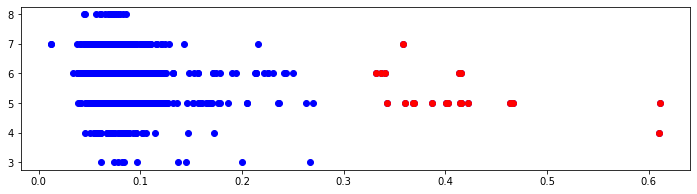

In [172]:
# красное вино
_ = outliers(df_red, ['chlorides'], .0135)

['volatile acidity']: 6 сэмпл., [ 126  127  672  690 1299 1312]


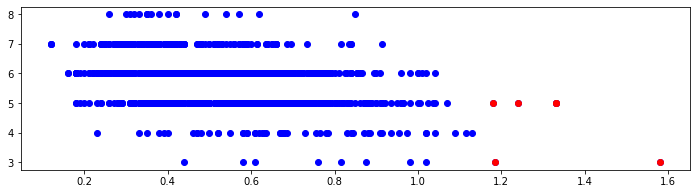

In [173]:
_ = outliers(df_red, ['volatile acidity'], .0035)

['chlorides']: 8 сэмпл., [ 470  665  669 1011 1193 1614 1841 4447]


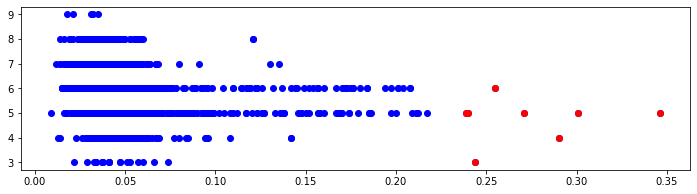

In [174]:
# белое вино
_ = outliers(df_white, ['chlorides'], .0015)

['volatile acidity']: 6 сэмпл., [ 360 1832 1927 2130 2757 4013]


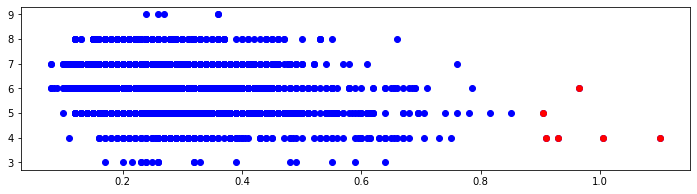

In [175]:
_ = outliers(df_white, ['volatile acidity'], .0012)

Анализ отдельных признаков дает возможность определить выбросы значений признаков (для наших датасетов малые значения выбросов не определяются в связи с наличием смещения значений параметров в сторону 0.0).  
Однако, делать вывод о качестве вина по отдельным признакам не логично, учитывая комплексный характер характеристик вин.

Теперь, используя тот же алгоритм определения выбросов IsolationForest, попробуем определить выбросы в пространстве нескольких признаков, а именно всех тех, важность которых определена в п.4.1:  
 - для белого вина 'fixed acidity', 'volatile acidity', 'chlorides', 'residual sugar','sulphates', 'alcohol'  
 - для красного вина 'fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide','sulphates', 'alcohol'

In [176]:
# красное вино
outliers(df_red, ['fixed acidity', 'volatile acidity', 'chlorides', \
                  'total sulfur dioxide','sulphates', 'alcohol'], .02).sort_values(by = 'quality')

['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol']: 32 сэмпл., [  17   19   81   83   86   91   92  106  151  169  181  198  226  258
  281  390  451  515  652  692  723  754 1051 1079 1081 1131 1165 1260
 1319 1370 1372 1566]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
5049,9.2,0.520,1.00,3.4,0.610,32.0,69.0,0.99960,2.74,2.00,9.4,4
4915,8.1,0.560,0.28,1.7,0.368,16.0,56.0,0.99680,3.11,1.28,9.3,5
5550,15.9,0.360,0.65,7.5,0.096,22.0,71.0,0.99760,2.98,0.84,14.9,5
5413,8.5,0.655,0.49,6.1,0.122,34.0,151.0,1.00100,3.31,1.14,9.3,5
6270,8.7,0.780,0.51,1.7,0.415,12.0,66.0,0.99623,3.00,1.17,9.2,5
5949,8.5,0.460,0.59,1.4,0.414,16.0,45.0,0.99702,3.03,1.34,9.2,5
5156,7.7,0.410,0.76,1.8,0.611,8.0,45.0,0.99680,3.06,1.26,9.4,5
6029,5.9,0.190,0.21,1.7,0.045,57.0,135.0,0.99341,3.32,0.44,9.5,5
6063,8.5,0.440,0.50,1.9,0.369,15.0,38.0,0.99634,3.01,1.10,9.4,5
5590,8.6,0.490,0.51,2.0,0.422,16.0,62.0,0.99790,3.03,1.17,9.0,5


In [177]:
# белое вино
outliers(df_white, ['fixed acidity', 'volatile acidity', 'chlorides', \
                        'residual sugar','sulphates', 'alcohol'], .005).sort_values(by = 'quality')

['fixed acidity', 'volatile acidity', 'chlorides', 'residual sugar', 'sulphates', 'alcohol']: 25 сэмпл., [ 283  669 1011 1193 1345 1362 1370 1811 1824 1832 2000 2570 2644 2757
 3684 3728 3738 3747 3875 3878 3889 4454 4477 4766 4789]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
294,9.1,0.590,0.38,1.60,0.066,34.0,182.0,0.99680,3.23,0.38,8.50,3
1034,7.9,0.640,0.46,10.60,0.244,33.0,227.0,0.99830,2.87,0.74,9.10,3
687,6.8,0.670,0.30,13.00,0.290,22.0,193.0,0.99840,3.08,0.67,9.00,4
3901,4.8,0.650,0.12,1.10,0.013,4.0,10.0,0.99246,3.32,0.36,13.50,4
1856,10.0,0.910,0.42,1.60,0.056,34.0,181.0,0.99680,3.11,0.46,10.00,4
1217,8.0,0.610,0.38,12.10,0.301,24.0,220.0,0.99930,2.94,0.48,9.20,5
1369,7.4,0.640,0.47,14.15,0.168,42.0,185.0,0.99840,2.90,0.49,9.30,5
4480,5.9,0.220,0.45,22.60,0.120,55.0,122.0,0.99636,3.10,0.35,12.80,5
1835,8.0,0.550,0.42,12.60,0.211,37.0,213.0,0.99880,2.99,0.56,9.30,5
1848,8.7,0.490,0.57,17.80,0.052,34.0,243.0,1.00070,2.98,0.82,9.00,5


Анализ выбросов по нескольким значимым признака одновременно, в целом, позволяет сделать несколько выводов:  
- экспертная оценка качества отражает либо преобладание значения одного параметра, либо некоторое сочетание значений нескольких параметров  
- экспертная оценка качества сильно снижается при увеличении значений 'volatile acidity' и 'chlorides', либо одного их этих параметров
- качественная оценка вина 'строгими' методами вряд ли возможна

* [Содержание](#Table-Of-Contents)

<a id="ML"></a>
# 4.3 Алгоритм предсказания качества вина

Для предсказания качества вина - целевой переменной 'quality' - воспользуемся алгоритмами классификации, невосприимчивыми к дисбалансу целевой переменной, а именно: RandomForestClassifier, DecisionTreeClassifier, ExtraTreeClassifier.  Состав признаков возьмем исходный.

In [180]:
# словарь параметров наших моделей
params = dict(DecisionTreeClassifier = \
                  [DecisionTreeClassifier(), \
                   dict(max_depth = np.linspace(3, 10, 8, dtype = 'int'), \
                        splitter = ['random', 'best'], \
                        max_features = ['auto', 'sqrt', 'log2'])], \
              ExtraTreeClassifier = \
                  [ExtraTreeClassifier(), \
                   dict(max_depth = np.linspace(3, 10, 8, dtype = 'int'), \
                        splitter = ['random', 'best'], \
                        max_features = ['auto', 'sqrt', 'log2'])], \
              RandomForestClassifier = \
                  [RandomForestClassifier(), \
                   dict(n_estimators = np.linspace(200, 1000, 20, dtype = 'int'), \
                        max_features = ['auto', 'sqrt', 'log2'])])

In [181]:
# без применения оверсэмплинга
# красное вино
X_tr, X_t, y_tr, y_t = split_and_smote(df_red, oversampling_ = False)

In [183]:
%%time
red_gscv_results = models_results(params, X_tr, X_t, y_tr, y_t, df_red.name)

----------------------
DecisionTreeClassifier
----------------------
ROC AUC на тестовом наборе: 0.6844511584363722
---------------------------------------------------------
Отчет о классификации:

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.40      0.20      0.27        10
           5       0.70      0.62      0.66       136
           6       0.55      0.69      0.61       127
           7       0.51      0.45      0.48        40
           8       0.00      0.00      0.00         4

    accuracy                           0.60       319
   macro avg       0.36      0.33      0.34       319
weighted avg       0.59      0.60      0.59       319

---------------------------------------------------------
Матрица ошибок:

[[ 0  0  0  1  1  0]
 [ 0  2  4  4  0  0]
 [ 0  1 84 46  5  0]
 [ 0  2 29 87  9  0]
 [ 0  0  3 18 18  1]
 [ 0  0  0  2  2  0]]
---------------------------------------------------------

In [184]:
# белое вино
X_tr, X_t, y_tr, y_t = split_and_smote(df_white, oversampling_ = False)

In [185]:
%%time
white_gscv_results = models_results(params, X_tr, X_t, y_tr, y_t, df_white.name)

----------------------
DecisionTreeClassifier
----------------------
ROC AUC на тестовом наборе: 0.6379744609914814
---------------------------------------------------------
Отчет о классификации:

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.19      0.09      0.12        32
           5       0.58      0.60      0.59       290
           6       0.58      0.63      0.60       437
           7       0.48      0.42      0.45       175
           8       0.32      0.17      0.22        35
           9       0.00      0.00      0.00         1

    accuracy                           0.55       974
   macro avg       0.30      0.27      0.28       974
weighted avg       0.53      0.55      0.54       974

---------------------------------------------------------
Матрица ошибок:

[[  0   0   2   2   0   0   0]
 [  0   3  14  14   1   0   0]
 [  0   7 175  94  14   0   0]
 [  2   5  98 277  49   6   0]
 [  0 

In [186]:
# с применением оверсэмплинга
# красное вино
X_tr, X_t, y_tr, y_t = split_and_smote(df_red, oversampling_ = True)

Размерность до применения SMOTE: X_tr (1274, 11), y_tr (1274,)
Размерность после применения SMOTE: X_tr (3264, 11), y_tr (3264,)


In [187]:
%%time
red_gscv_results = models_results(params, X_tr, X_t, y_tr, y_t, df_red.name + '_' + 'ovrsampl')

----------------------
DecisionTreeClassifier
----------------------
ROC AUC на тестовом наборе: 0.6512465479303708
---------------------------------------------------------
Отчет о классификации:

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.12      0.50      0.19        10
           5       0.63      0.49      0.55       136
           6       0.59      0.48      0.53       127
           7       0.41      0.60      0.49        40
           8       0.14      0.25      0.18         4

    accuracy                           0.50       319
   macro avg       0.32      0.39      0.32       319
weighted avg       0.56      0.50      0.52       319

---------------------------------------------------------
Матрица ошибок:

[[ 0  1  1  0  0  0]
 [ 1  5  3  1  0  0]
 [ 1 22 67 32 14  0]
 [ 0 14 32 61 18  2]
 [ 0  1  3  8 24  4]
 [ 0  0  0  1  2  1]]
---------------------------------------------------------

In [188]:
# белое вино
X_tr, X_t, y_tr, y_t = split_and_smote(df_white, oversampling_ = True)

Размерность до применения SMOTE: X_tr (3896, 11), y_tr (3896,)
Размерность после применения SMOTE: X_tr (12243, 11), y_tr (12243,)


In [189]:
%%time
white_gscv_results = models_results(params, X_tr, X_t, y_tr, y_t, df_white.name + '_' + 'ovrsampl')

----------------------
DecisionTreeClassifier
----------------------
ROC AUC на тестовом наборе: 0.643647649099738
---------------------------------------------------------
Отчет о классификации:

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.15      0.53      0.23        32
           5       0.53      0.55      0.54       290
           6       0.59      0.24      0.34       437
           7       0.37      0.47      0.41       175
           8       0.12      0.49      0.20        35
           9       0.00      0.00      0.00         1

    accuracy                           0.39       974
   macro avg       0.25      0.32      0.25       974
weighted avg       0.50      0.39      0.40       974

---------------------------------------------------------
Матрица ошибок:

[[  0   1   1   1   0   1   0]
 [  0  17   7   2   4   2   0]
 [  6  57 160  27  18  21   1]
 [  9  32 123 103 105  65   0]
 [  6  

1. Модель не предсказала 2 класса "3" и "9" в наборе белых вин и 2 класса "3" и "4" в наборе красных вин, т.к. было мало сэмплов из этих категорий. Алгоритм балансировки целевой 
переменной также не помог.  
2. По категориям "5", "6", "7", которые можно отнести к общей категории качества вин "средние", модель показала
самый высокий, но не удовлетворительный результат: полнота и точность 0.43 - 0.82.
3. Наиболее проблемные зоны - границы классов.

* [Содержание](#Table-Of-Contents)

<a id="Conclusion"></a>
# 5. Выводы

1. Актуальные для наборов данных признаки:  
- красное вино - ['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide','sulphates', 'alcohol']  
- белое вино - ['fixed acidity', 'volatile acidity', 'chlorides', 'residual sugar', 'sulphates', 'alcohol']  
2. Анализ выбросов по нескольким значимым признака одновременно, в целом, позволяет сделать несколько выводов:  
- экспертная оценка качества отражает либо преобладание значения одного параметра, либо некоторое сочетание значений нескольких параметров  
- экспертная оценка качества сильно снижается при увеличении значений 'volatile acidity' и 'chlorides', либо одного их этих параметров
- качественная оценка вина 'строгими' методами вряд ли возможна
3. В результате работы алгоритма классификации лучшее качество предсказания целевой переменной 'quality' достигается для "средних" значений 5, 6 и 7, что объясняется наличием большего количества сэмплов с этими значениями 'quality' и меньшей дисперсией значений важных признаков в этих сэмплах.
4. Из матрицы ошибок видно, что наиболее проблемные зоны - границы классов качества вина.
5. Классы с малым количеством сэмплов не определились.


* [Содержание](#Table-Of-Contents)